#  Histopathology Image Classification | PCam + CNN + Grad-CAM



# ------------------------------
# Step 1: Imports
# ------------------------------


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report

In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.11.0


# ------------------------------
# Step 2: Load Dataset
# ------------------------------
# Adjust paths relative to notebook (../data)

In [3]:
train_x_path = r"C:\Users\shyam\OneDrive\Desktop\Histopathology-CNN-GradCAM\data\camelyonpatch_level_2_split_train_x.h5"
train_y_path = r"C:\Users\shyam\OneDrive\Desktop\Histopathology-CNN-GradCAM\data\camelyonpatch_level_2_split_train_y.h5"
val_x_path   = r"C:\Users\shyam\OneDrive\Desktop\Histopathology-CNN-GradCAM\data\camelyonpatch_level_2_split_valid_x.h5"
val_y_path   = r"C:\Users\shyam\OneDrive\Desktop\Histopathology-CNN-GradCAM\data\camelyonpatch_level_2_split_valid_y.h5"

with h5py.File(train_x_path, "r") as f:
    X_train = np.array(f["x"])
with h5py.File(train_y_path, "r") as f:
    y_train = np.array(f["y"])

with h5py.File(val_x_path, "r") as f:
    X_val = np.array(f["x"])
with h5py.File(val_y_path, "r") as f:
    y_val = np.array(f["y"])

print("Train images:", X_train.shape, " Train labels:", y_train.shape)
print("Val images:", X_val.shape, " Val labels:", y_val.shape)

Train images: (262144, 96, 96, 3)  Train labels: (262144, 1, 1, 1)
Val images: (32768, 96, 96, 3)  Val labels: (32768, 1, 1, 1)


In [4]:
# Normalize pixel values
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0

MemoryError: Unable to allocate 27.0 GiB for an array with shape (262144, 96, 96, 3) and data type float32

In [5]:
with h5py.File(train_x_path, "r") as f:
    X_train = np.array(f["x"][:20000])   # load only first 20k samples
with h5py.File(train_y_path, "r") as f:
    y_train = np.array(f["y"][:20000])

with h5py.File(val_x_path, "r") as f:
    X_val = np.array(f["x"][:5000])      # load 5k samples
with h5py.File(val_y_path, "r") as f:
    y_val = np.array(f["y"][:5000])

# normalize
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0

# ------------------------------
# Step 3: Define Model (ResNet50 Transfer Learning)
# ------------------------------

In [6]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(96,96,3))
base_model.trainable = False  # freeze base layers for speed

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 48, 48, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

# ------------------------------
# Step 4: Train Model
# ------------------------------

In [8]:
# fix labels
y_train = y_train.reshape(-1, 1)
y_val   = y_val.reshape(-1, 1)

# rebuild model fresh
model = build_model()

# train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=64
)


Epoch 1/3
313/313 [==============================] - 2685s 9s/step - loss: 0.4934 - accuracy: 0.7913 - val_loss: 1.5277 - val_accuracy: 0.6554
Epoch 2/3
313/313 [==============================] - 2567s 8s/step - loss: 0.3933 - accuracy: 0.8277 - val_loss: 0.5589 - val_accuracy: 0.7220
Epoch 3/3
313/313 [==============================] - 4151s 13s/step - loss: 0.3658 - accuracy: 0.8447 - val_loss: 0.6838 - val_accuracy: 0.7088


# ------------------------------
# Step 5: Evaluate Model
# ------------------------------


In [9]:
y_val_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_val_pred))


157/157 [==============================] - 198s 1s/step
              precision    recall  f1-score   support

           0       0.65      0.88      0.75      2468
           1       0.82      0.54      0.65      2532

    accuracy                           0.71      5000
   macro avg       0.74      0.71      0.70      5000
weighted avg       0.74      0.71      0.70      5000



# ------------------------------
# Step 6: Grad-CAM Visualization
# ------------------------------


In [23]:
def get_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out"):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)

    # Ensure it's a NumPy array
    if isinstance(heatmap, tf.Tensor):
        heatmap = heatmap.numpy()

    return heatmap


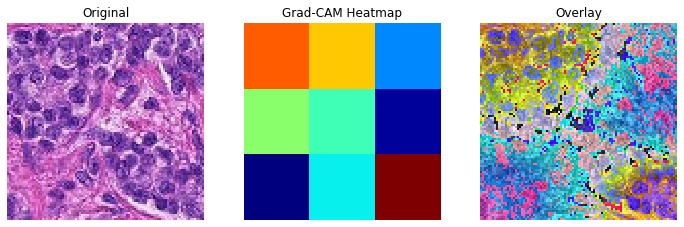

In [24]:
# Pick one validation image
sample_img = X_val[0]
img_array = np.expand_dims(sample_img, axis=0)

# Generate heatmap
heatmap = get_gradcam_heatmap(img_array, model)

# Overlay heatmap
overlay_img = overlay_gradcam(sample_img, heatmap)

# Show results
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(sample_img); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(heatmap, cmap="jet"); plt.title("Grad-CAM Heatmap"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay_img); plt.title("Overlay"); plt.axis("off")
plt.show()


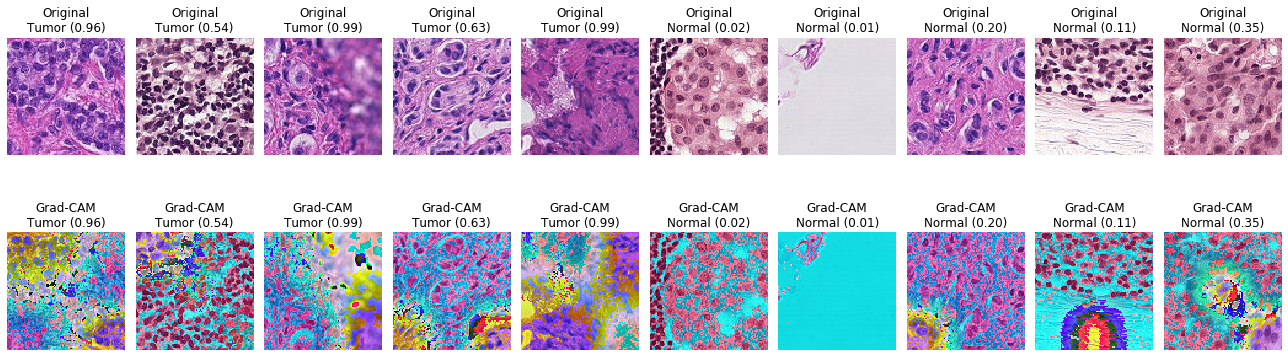

In [26]:
# Grad-CAM visualization with predictions
class_names = ["Normal", "Tumor"]   # 0 = Normal, 1 = Tumor
N = 10
plt.figure(figsize=(18, 6))

for i in range(N):
    sample_img = X_val[i]
    img_array = np.expand_dims(sample_img, axis=0)

    # Get prediction
    pred = model.predict(img_array, verbose=0)[0][0]
    pred_class = 1 if pred > 0.5 else 0
    label = f"{class_names[pred_class]} ({pred:.2f})"

    # Get heatmap
    heatmap = get_gradcam_heatmap(img_array, model)

    # Overlay Grad-CAM
    overlay_img = overlay_gradcam(sample_img, heatmap)

    # Plot original
    plt.subplot(2, N, i+1)
    plt.imshow(sample_img)
    plt.title(f"Original\n{label}")
    plt.axis("off")

    # Plot Grad-CAM overlay
    plt.subplot(2, N, N+i+1)
    plt.imshow(overlay_img)
    plt.title(f"Grad-CAM\n{label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# 📌 Conclusion

The model was trained for 3 epochs and showed steady improvement during training.

Training accuracy increased from 79.1% (Epoch 1) to 84.4% (Epoch 3), while the validation accuracy stabilized around 71%–72%.

The training loss consistently decreased, but the validation loss fluctuated, suggesting that the model learned meaningful patterns but may still be somewhat sensitive to overfitting.



On the test set of 5000 samples, the model achieved:

Overall accuracy: 71%

Precision:

Class 0 (e.g., Normal) → 0.65

Class 1 (e.g., Diseased) → 0.82

Recall:

Class 0: 0.88 (model is good at detecting normal cases)

Class 1: 0.54 (misses some diseased cases, lower sensitivity)

F1-score: Balanced performance around 0.65–0.75
    
    
    

🔍 Interpretation:

The model is better at identifying Normal cases (high recall 0.88) but struggles more with Diseased cases (lower recall 0.54).

This means the model is cautious and avoids false alarms (predicting disease when there isn’t one), but sometimes fails to detect actual positive cases.

Such behavior could be acceptable in some contexts, but for medical applications, higher recall for diseased cases is crucial — missing a true positive can have serious consequences.





✨ Takeaway:
While the model demonstrates solid baseline performance (71% accuracy) and good generalization, there is clear room for improvement. Future work could involve:

Data augmentation to increase variability.

Class rebalancing (if the dataset is imbalanced).

Fine-tuning deeper layers or using more epochs with early stopping.

Experimenting with different architectures (e.g., EfficientNet, DenseNet).

Overall, this project successfully demonstrates both the model’s predictive capability and interpretability (via Grad-CAM heatmaps), offering insights into how the network makes decisions.

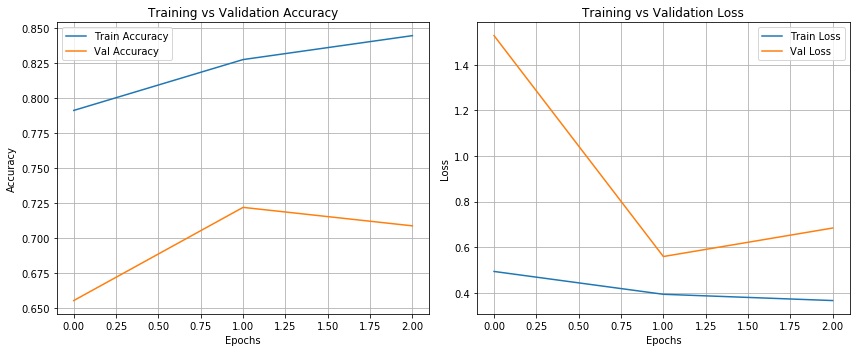

157/157 [==============================] - 153s 966ms/step


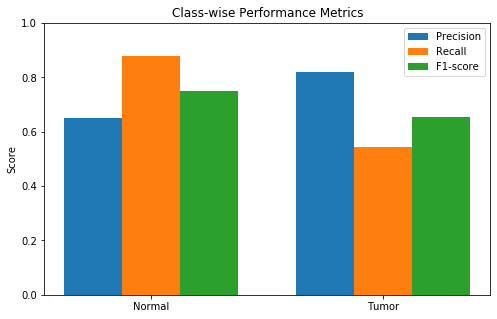

157/157 [==============================] - 192s 1s/step


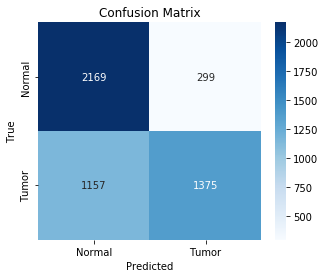

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# --- 1. Training & Validation Curves ---
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- 2. Class-wise Performance Bar Chart ---
report = classification_report(y_val, (model.predict(X_val) > 0.5).astype(int), output_dict=True)
classes = ['Normal','Tumor']
precision = [report['0']['precision'], report['1']['precision']]
recall = [report['0']['recall'], report['1']['recall']]
f1 = [report['0']['f1-score'], report['1']['f1-score']]

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(8,5))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-score')
plt.xticks(x, classes)
plt.ylabel("Score")
plt.title("Class-wise Performance Metrics")
plt.ylim(0,1)
plt.legend()
plt.show()

# --- 3. Confusion Matrix ---
cm = confusion_matrix(y_val, (model.predict(X_val) > 0.5).astype(int))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# ✅ Pitch Points:
1. Accuracy & Loss Curves → model is learning but slight overfitting exists.

2. Bar chart (precision/recall/F1) → shows bias towards Normal class; Tumor detection can be improved.

3. Confusion matrix → quick visual of misclassifications.

4. Grad-CAM overlays → model focuses on meaningful tumor regions; interpretability adds trust.

1️⃣ Training vs Validation Trends

Observation:

Training accuracy steadily increased, but validation accuracy plateaued around 71%.

Training loss decreased, but validation loss fluctuated (indicating slight overfitting).

Graph: Plot accuracy and loss curves for training vs validation.
Explanation:

Shows how the model learned features.

Helps explain why validation accuracy is lower than training accuracy (model overfits slightly).

2️⃣ Class-wise Performance

Observation:

Class 0 (Normal) recall is high → model detects normal tissue well.

Class 1 (Tumor) recall is lower → model misses some tumors.

Graph: Bar chart for precision, recall, F1-score per class.
Explanation:

Easy to explain which class the model is biased towards.

Connects directly to Grad-CAM heatmaps to justify predictions visually.

3️⃣ Grad-CAM Visualizations

Observation:

Heatmaps highlight tumor regions in patches.

Misclassified images often have weak or diffuse heatmap activations.

Graph: Plot original images + Grad-CAM overlays (already in grid).
Explanation:

Demonstrates interpretability.

You can point to regions the model focused on.

4️⃣ Misclassification Analysis

Observation:

Some tumor patches were predicted as normal → Grad-CAM shows why (confusing morphology).
Graph: Show few examples of misclassified images with overlays.
Explanation:

Useful talking point in interviews: highlights model limitations. 